Vítejte u domácí úlohy do SUI.
V rámci úlohy Vás čeká několik cvičení, v nichž budete doplňovat poměrně malé fragmenty kódu, místo na ně je vyznačené jako `pass` nebo `None`.
Pokud se v buňce s kódem již něco nachází, využijte/neničte to.
V dvou případech se očekává textová odpověď, tu uvedete přímo do zadávající buňky.
Buňky nerušte ani nepřidávejte.

Maximálně využívejte `numpy` a `torch` pro hromadné operace na celých polích.
S výjimkou generátoru minibatchí by se nikde neměl objevit cyklus jdoucí přes jednotlivé příklady.

U všech cvičení je uveden počet bodů za funkční implementaci a orientační počet potřebných řádků.
Berte ho prosím opravdu jako orientační, pozornost mu věnujte pouze, pokud ho významně překračujete.
Mnoho zdaru!

# Informace o vzniku řešení
Vyplňte následující údaje **(3 údaje, 0 bodů)**

* Jméno autora: Jakub Sadílek
* Login autora: xsadil07
* Datum vzniku: 1.11.2020

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy.stats

# Přípravné práce
Prvním úkolem v této domácí úloze je načíst data, s nimiž budete pracovat.
Vybudujte jednoduchou třídu, která se umí zkonstruovat z cesty k negativním a pozitivním příkladům, a bude poskytovat:
- pozitivní a negativní příklady (`dataset.pos`, `dataset.neg` o rozměrech [N, 7])
- všechny příklady a odpovídající třídy (`dataset.xs` o rozměru [N, 7], `dataset.targets` o rozměru [N])

K načítání dat doporučujeme využít `np.loadtxt()`.
Netrapte se se zapouzdřování a gettery, berte třídu jako Plain Old Data.

Načtěte trénovací (`{positives,negatives}.trn`), validační (`{positives,negatives}.val`) a testovací (`{positives,negatives}.tst`) dataset, pojmenujte je po řadě (`train_dataset`, `val_dataset`, `test_dataset`). 

**(6+3 řádků, 1 bod)** 


In [2]:
class dataset:
    def __init__(self, positives, negatives):
        self.pos = np.loadtxt(positives)
        self.neg = np.loadtxt(negatives)
        self.xs = np.concatenate((self.pos, self.neg))
        self.targets = np.concatenate((np.ones(len(self.pos)),np.zeros(len(self.neg))))
        
train_dataset = dataset("positives.trn", "negatives.trn")
val_dataset = dataset("positives.val", "negatives.val")
test_dataset = dataset("positives.tst", "negatives.tst")

print('positives', train_dataset.pos.shape)
print('negatives', train_dataset.neg.shape)
print('xs', train_dataset.xs.shape)
print('targets', train_dataset.targets.shape)

positives (2280, 7)
negatives (6841, 7)
xs (9121, 7)
targets (9121,)


V řadě následujících cvičení budete pracovat s jedním konkrétním příznakem. Naimplementujte pro začátek funkci, která vykreslí histogram rozložení pozitivních a negativních příkladů (`plt.hist()`). Nezapomeňte na legendu, ať je v grafu jasné, které jsou které. Funkci zavolejte dvakrát, vykreslete histogram příznaku `5` -- tzn. šestého ze sedmi -- pro trénovací a validační data **(5 řádků, 1 bod)**.

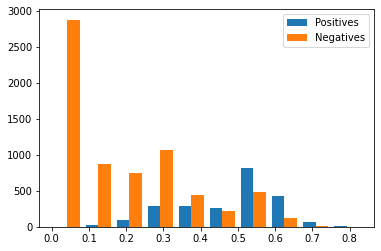

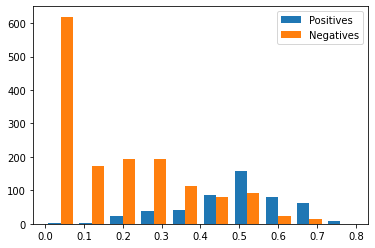

In [3]:
FOI = 5  # Feature Of Interest

def plot_data(poss, negs):
    plt.hist([poss,negs], label=["Positives", "Negatives"]) 
    plt.legend(loc="upper right")
    plt.show()

plot_data(train_dataset.pos[:, FOI], train_dataset.neg[:, FOI])
plot_data(val_dataset.pos[:, FOI], val_dataset.neg[:, FOI])

### Evaluace klasifikátorů
Než přistoupíte k tvorbě jednotlivých klasifikátorů, vytvořte funkci pro jejich vyhodnocování.
Nechť se jmenuje `evaluate` a přijímá po řadě klasifikátor, pole dat (o rozměrech [N] nebo [N, F]) a pole tříd ([N]).
Jejím výstupem bude _přesnost_, tzn. podíl správně klasifikovaných příkladů.

Předpokládejte, že klasifikátor poskytuje metodu `.prob_class_1(data)`, která vrací pole posteriorních pravděpodobností třídy 1 (tj. p(y=1|x)) pro daná data.
Evaluační funkce bude muset provést tvrdé prahování (na hodnotě 0.5) těchto pravděpodobností a srovnání získaných rozhodnutí s referenčními třídami.
Využijte fakt, že `numpy`ovská pole lze mj. porovnávat mezi sebou i se skalárem.

**(3 řádky, 1 bod)**

In [4]:
def evaluate(classifier, inputs, targets):
    arr = np.rint(classifier.prob_class_1(inputs))
    arr = np.equal(arr, targets)
    return np.count_nonzero(arr)/np.size(arr)

class Dummy:
    def prob_class_1(self, xs):
        return np.asarray([0.2, 0.7, 0.7])

print(evaluate(Dummy(), None, np.asarray([0, 0, 1])))  # should be 0.66...

0.6666666666666666


### Baseline
Vytvořte klasifikátor, který ignoruje vstupní hodnotu dat.
Jenom v konstruktoru dostane třídu, kterou má dávat jako tip pro libovolný vstup.
Nezapomeňte, že jeho metoda `.prob_class_1(data)` musí vracet pole správné velikosti, využijte `np.ones` nebo `np.full`.

**(4 řádky, 1 bod)**

In [5]:
class PriorClassifier:
    def __init__(self, tip):
        self.value = tip
    
    def prob_class_1(self, data):
        return np.full(np.shape(data), self.value)
        

baseline = PriorClassifier(0)
val_acc = evaluate(baseline, val_dataset.xs[:, FOI], val_dataset.targets)
print('Baseline val acc:', val_acc)

Baseline val acc: 0.75


# Generativní klasifikátory
V této  části vytvoříte dva generativní klasifikátory, oba založené na Gaussovu rozložení pravděpodobnosti.

Začněte implementací funce, která pro daná 1-D data vrátí Maximum Likelihood odhad střední hodnoty a směrodatné odchylky Gaussova rozložení, které data modeluje.
Funkci využijte pro natrénovaní dvou modelů: pozitivních a negativních příkladů.
Získané parametry -- tzn. střední hodnoty a směrodatné odchylky -- vypište.

**(5 řádků, 0.5 bodu)**

In [6]:
def normalDist(data):
    return np.mean(data), np.std(data)
    
print("Positives (mean, deviation): " + str(normalDist(train_dataset.pos[:, FOI])))
print("Negatives (mean, deviation): " + str(normalDist(train_dataset.neg[:, FOI])))

Positives (mean, deviation): (0.478428821613158, 0.12971703647258465)
Negatives (mean, deviation): (0.17453641132613792, 0.17895975196381242)


Ze získaných parametrů vytvořte `scipy`ovská gaussovská rozložení `scipy.stats.norm`.
S využitím jejich metody `.pdf()` vytvořte graf, v němž srovnáte skutečné a modelové rozložení pozitivních a negativních příkladů.
Rozsah x-ové osy volte od -0.5 do 1.5 (využijte `np.linspace`) a u volání `plt.hist()` nezapomeňte nastavit `density=True`, aby byl histogram normalizovaný a dal se srovnávat s modelem.

**(2+8 řádků, 1 bod)**

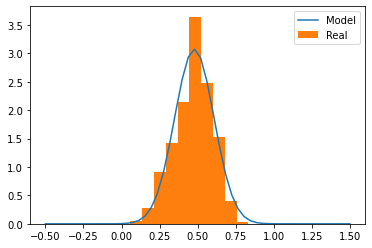

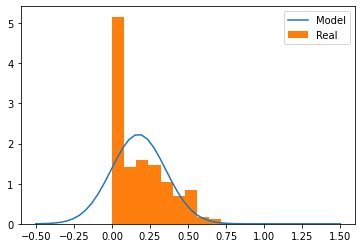

In [7]:
def compareDistribution(data, mean, deviation):
    x = np.linspace(-0.5, 1.5)
    fig = scipy.stats.norm(loc=mean, scale=deviation)
    plt.plot(x, fig.pdf(x), label="Model")
    plt.hist(data, density=True, label="Real")
    plt.legend()
    plt.show()
    
compareDistribution(train_dataset.pos[:, FOI], *normalDist(train_dataset.pos[:, FOI]))
compareDistribution(train_dataset.neg[:, FOI], *normalDist(train_dataset.neg[:, FOI]))

Naimplementujte binární generativní klasifikátor. 
Při konstrukci přijímá dvě rozložení poskytující metodu `.pdf()` a odpovídající apriorní pravděpodobnost tříd.
Jako všechny klasifikátory v této domácí úloze poskytuje metodu `prob_class_1()`.

**(9 řádků, 2 body)**

In [8]:
class GenerativeClassifier:
    def __init__(self, d1, d2, p1, p2):
        self.d1 = d1
        self.d2 = d2
        self.p1 = p1
        self.p2 = p2
        
    def prob_class_1(self, data):
        return (self.d1.pdf(data)*self.p1)/(self.d1.pdf(data)*self.p1 + self.d2.pdf(data)*self.p2)

Nainstancujte dva generativní klasifikátory: jeden s rovnoměrnými priory a jeden s apriorní pravděpodobností 0.75 pro třídu 0 (negativní příklady).
Pomocí funkce `evaluate()` vyhodnoťte jejich úspěšnost na validačních datech.

**(2 řádky, 1 bod)**

In [9]:
classifier_flat_prior = GenerativeClassifier(scipy.stats.norm(*normalDist(train_dataset.pos[:, FOI])), scipy.stats.norm(*normalDist(train_dataset.neg[:, FOI])), 0.5, 0.5)
classifier_full_prior = GenerativeClassifier(scipy.stats.norm(*normalDist(train_dataset.pos[:, FOI])), scipy.stats.norm(*normalDist(train_dataset.neg[:, FOI])), 0.25, 0.75)

print('flat:', evaluate(classifier_flat_prior, val_dataset.xs[:, FOI], val_dataset.targets))
print('full:', evaluate(classifier_full_prior, val_dataset.xs[:, FOI], val_dataset.targets))

flat: 0.809
full: 0.8475


Vykreslete průběh posteriorní pravděpodobnosti třídy 1 jako funkci příznaku 5 pro oba klasifikátory, opět v rozsahu <-0.5; 1.5>.
Do grafu zakreslete i histogramy rozložení trénovacích dat, opět s `density=True` pro zachování dynamického rozsahu.

**(8 řádků, 1 bod)**

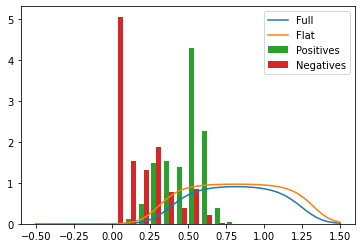

In [10]:
def posteriorProb(data, full, flat):
    x = np.linspace(-0.5, 1.5)
    plt.plot(x, full.prob_class_1(x), label="Full")
    plt.plot(x, flat.prob_class_1(x), label="Flat")
    plt.hist([data.pos[:, FOI], data.neg[:, FOI]], density=True, label=["Positives", "Negatives"])
    plt.legend()
    plt.show()
    
posteriorProb(train_dataset, classifier_full_prior, classifier_flat_prior)

Interpretujte, přímo v této textové buňce, každou rozhodovací hranici, která je v grafu patrná **(3 věty, 2 body)**: Nachází se zde 4 rozhodovácí hranice při hodnotě 0.5 na Y ose pro obě křivky. První je patrná zhruba v okolí 0.3, kde histogram pozitivních a negativních dat je víceméně vyrovnaný a tomto bodě by se měla křivka s rovnoměrnými priory (flat) blížit hodnotě 0.5 jak je z grafu patrné. Druhá hranice se nachází zhruba v bodě 0.45, kde se druhá křivka (full) s aprioritní pravděpodobnosti v poměru 75:25 pro negativní případy blíží hodnotě 0.5, kde jsou ovšem hodnoty dat v histogramu také v pomětu 75:25. Jelikož se jedná o normální rozdělení, jsou zde i odpovídající sestupné hranice pro obě křivky v pravé části grafu.

# Diskriminativní klasifikátory
V následující části budete přímo modelovat posteriorní pravděpodobnost třídy 1.
Modely budou založeny na PyTorchi, ten si prosím nainstalujte.
GPU rozhodně nepotřebujete, veškeré výpočty budou velmi rychlé, ne-li bleskové.

Do začátku máte poskytnutou třídu klasifikátoru z jednoho příznaku.

In [11]:
import torch
import torch.nn.functional as F

class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w = torch.nn.parameter.Parameter(torch.tensor([1.0]))
        self.b = torch.nn.parameter.Parameter(torch.tensor([0.0]))
        
    def forward(self, x):
        return torch.sigmoid(self.w*x + self.b)
    
    def prob_class_1(self, x):
        prob = self(torch.from_numpy(x))
        return prob.detach().numpy()

Pro trénovaní diskriminativních modelů budete potřebovat minibatche.
Implementujte funkci, která je bude z daných vstupních a cílových hodnot vytvářet.
Výsledkem musí být možno iterovat, ideálně funkci napište jako generátor (využijte klíčové slovo `yield`).
Jednotlivé prvky výstupu budou dvojice PyTorchových `FloatTensor`ů (musíte zkonvertovat z numpy a nastavit typ) -- první prvek vstupní data, druhý očekávané výstupy.
Počítejte s tím, že vstup bude `numpy`ovské pole, rozumná implementace využije `np.random.permutation()` a [Advanced Indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Připravený kód funkci použije na konstrukci tří minibatchí pro trénování identity, měli byste vidět celkem pět prvků náhodně uspořádaných do dvojic, ovšem s tím, že s sebou budou mít odpovídající výstupy.

**(6 řádků, 2 body)**

In [55]:
def batch_provider(xs, targets, batch_size=10):
    order = np.random.permutation(len(xs))
    xs = xs[order]
    targets = targets[order]

    for i in range(0, len(xs), batch_size):
        yield torch.tensor(xs[i:i+batch_size], dtype=torch.float32), torch.tensor(targets[i:i+batch_size], dtype=torch.float32)

inputs = np.asarray([1.0, 2.0, 3.0, 4.0, 5.0])
targets = np.asarray([1.0, 2.0, 3.0, 4.0, 5.0])
for x, t in batch_provider(inputs, targets, 2):
    print(f'x: {x}, t: {t}')

x: tensor([3., 5.]), t: tensor([3., 5.])
x: tensor([2., 4.]), t: tensor([2., 4.])
x: tensor([1.]), t: tensor([1.])


Dalším krokem je implementovat funkci, která model vytvoří a natrénuje.
Jejím výstupem bude (1) natrénovaný model, (2) průběh trénovací loss a (3) průběh validační přesnosti.
Jako model vracejte ten, který dosáhne nejlepší validační přesnosti.
Jako loss použijte binární cross-entropii (`F.binary_cross_entropy()`), akumulujte ji přes minibatche a logujte průměr.
Pro výpočet validační přesnosti využijte funkci `evaluate()`.
Oba průběhy vracejte jako obyčejné seznamy.

V implementaci budete potřebovat dvě zanořené smyčky: jednu pro epochy (průchody přes celý dataset) a uvnitř druhou, která bude iterovat přes jednotlivé minibatche.
Na konci každé epochy vyhodnoťte model na validačních datech.
K datasetům (trénovacímu a validačnímu) přistupujte bezostyšně jako ke globálním proměnným.

**(cca 14 řádků, 3 body)**

In [56]:
def train_single_fea_llr(fea_no, nb_epochs, lr, batch_size):
    ''' fea_no -- which feature to train on
        nb_epochs -- how many times to go through the full training data
        lr -- learning rate
        batch_size -- size of minibatches
    '''
    model = LogisticRegression()
    best_model = copy.deepcopy(model)
    losses = []
    accuracies = []
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    best_acc = 0.0
    for epoch in range(nb_epochs):
        acc = 0.0
        l = 0.0
        i = 0
        for x, y in batch_provider(train_dataset.xs[:, fea_no], train_dataset.targets, batch_size):
            prediction = model.forward(x)
            loss = F.binary_cross_entropy(prediction, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            l += loss.item()
            acc = evaluate(model, val_dataset.xs[:, fea_no], val_dataset.targets)
            i += 1
        
        accuracies.append(acc)
        losses.append(l/i)
        if (acc > best_acc):
            best_model = copy.deepcopy(model)
            best_acc = acc
        
    return best_model, losses, accuracies

Funkci zavolejte a natrénujte model.
Uveďte zde parametry, které vám dají slušný výsledek.
Měli byste dostat přesnost srovnatelnou s generativním klasifikátorem s nastavenými priory.
Neměli byste potřebovat víc než 100 epoch.
Vykreslete průběh trénovací loss a validační přesnosti, osu x značte v epochách.

V druhém grafu vykreslete histogramy trénovacích dat a pravděpodobnost třídy 1 pro x od -0.5 do 1.5, podobně jako výše u generativních klasifikátorů.
Při výpočtu výstupů využijte `with torch.no_grad():`.
**(1 + 6 + 9 řádků, 1 bod)**

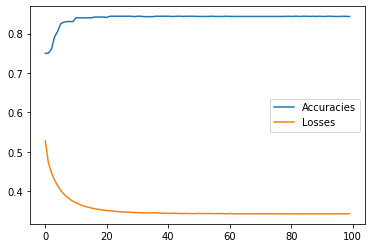

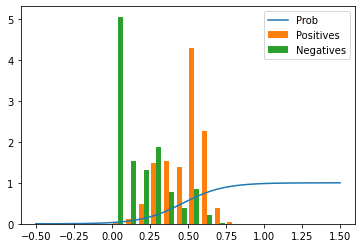

In [57]:
def plotTrain(model, losses, accuracies, data):
    x = np.linspace(0, 100)
    plt.plot(accuracies, label="Accuracies")
    plt.plot(losses, label="Losses")
    plt.legend()
    plt.show()
    
    x = np.linspace(-0.5, 1.5)
    with torch.no_grad():
        prob = model.prob_class_1(x)
    plt.plot(x, prob, label="Prob")
    plt.hist([data.pos[:, FOI], data.neg[:, FOI]], density=True, label=["Positives", "Negatives"])
    plt.legend()
    plt.show()
    
regressionModel, losses, accuracies = train_single_fea_llr(5, 100, 0.01, 5)
plotTrain(regressionModel, losses, accuracies, train_dataset)

## Všechny vstupní příznaky
V posledním cvičení natrénujete logistickou regresi, která využije všech sedm vstupních příznaků.

Prvním krokem je naimplementovat příslusný model.
Bezostyšně zkopírujte tělo třídy `LogisticRegresion` a upravte ji tak, aby zvládala libovolný počet vstupů, využijte `torch.nn.Linear`.
U výstupu metody `.forward()` dejte pozor, aby měl výstup tvar `[N]`; pravděpodobně budete potřebovat `squeeze`.

**(9 řádků, 1 bod)**

In [58]:
class LogisticRegressionAll(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.m = torch.nn.Linear(7, 1)
        
    def forward(self, x):
        return torch.squeeze(torch.sigmoid(self.m(x.float())), dim=1)
    
    def prob_class_1(self, x):
        prob = self(torch.from_numpy(x))
        return prob.detach().numpy()

Podobně jako u jednodimenzionálni regrese implementujte funkci pro trénovaní plné logistické regrese.
V ideálním případě vyfaktorujete společnou implementaci, které budete pouze předávat různá trénovací a validační data.

Zvídaví mohou zkusit `Adam`a jako optimalizátor namísto obyčejného `SGD`.

Funkci zavolejte, natrénujte model.
Opět vykreslete průběh trénovací loss a validační přesnosti.
Měli byste se s přesností dostat nad 90 %.

**(ne víc než cca 30 řádků při kopírování, 1 bod)**

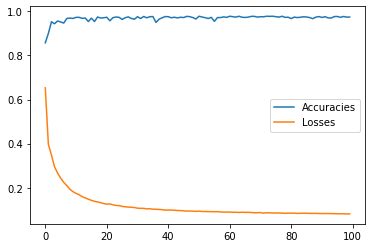

In [74]:
def train_all_fea_llr(nb_epochs, lr, batch_size):
    ''' nb_epochs -- how many times to go through the full training data
        lr -- learning rate
        batch_size -- size of minibatches
    '''
    model = LogisticRegressionAll()
    best_model = copy.deepcopy(model)
    losses = []
    accuracies = []
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    best_acc = 0.0
    for epoch in range(nb_epochs):
        acc = 0.0
        l = 0.0
        i = 0
        for x, y in batch_provider(train_dataset.xs, train_dataset.targets, batch_size):
            prediction = model.forward(x)
            loss = F.binary_cross_entropy(prediction, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            l += loss.item()
            acc = evaluate(model, val_dataset.xs, val_dataset.targets)
            i += 1
        
        accuracies.append(acc)
        losses.append(l/i)
        if (acc > best_acc):
            best_model = copy.deepcopy(model)
            best_acc = acc
        
    return best_model, losses, accuracies

def plotRegModel(losses, accuracies):
    plt.plot(accuracies, label="Accuracies")
    plt.plot(losses, label="Losses")
    plt.legend()
    plt.show()

regressionModelAll, lossesAll, accuraciesAll = train_all_fea_llr(100, 0.01, 64)
plotRegModel(lossesAll, accuraciesAll)

# Závěrem
Konečně vyhodnoťte všech pět vytvořených klasifikátorů na testovacích datech. Stačí doplnit jejich názvy a předat jim příznaky, na které jsou zvyklé.

**(0.5 bodu)**

In [75]:
xs_full = test_dataset.xs
xs_foi = test_dataset.xs[:, FOI]
targets = test_dataset.targets

print('Baseline:', evaluate(baseline, xs_foi, targets))
print('Generative classifier (w/o prior):', evaluate(classifier_flat_prior, xs_foi, targets))
print('Generative classifier (correct):', evaluate(classifier_full_prior, xs_foi, targets))
print('Logistic regression:', evaluate(regressionModel, xs_foi, targets))
print('logistic regression all features:', evaluate(regressionModelAll, xs_full, targets))

Baseline: 0.75
Generative classifier (w/o prior): 0.8
Generative classifier (correct): 0.847
Logistic regression: 0.852
logistic regression all features: 0.9665


Blahopřejeme ke zvládnutí domácí úlohy! Notebook spusťte načisto (Kernel -> Restart & Run all), vyexportuje jako PDF a odevzdejte pojmenovaný svým loginem.

Mimochodem, vstupní data nejsou synteticky generovaná. Nasbírali jsme je z projektu; Vaše klasifikátory v této domácí úloze predikují, že daný hráč vyhraje; takže by se daly použít jako heuristika pro ohodnocování listových uzlů ve stavovém prostoru hry.
Pro představu, odhadujete to z pozic pět kol před koncem partie pro daného hráče.
Poskytnuté příznaky popisují globální charakteristiky stavu hry jako je například poměr délky hranic předmětného hráče k ostatním hranicím.